# Tansania Travel Spendings Predictions

## Importing libraries

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

## Importing the dataset

In [121]:
df_train = pd.read_csv('data/Train.csv')
df_test  = pd.read_csv('data/Test.csv')


## Overview of the dataset

There are 4809 rows and 23 columns in this dataset.

In [122]:
df_train.shape

(4809, 23)

In [123]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4809 entries, 0 to 4808
Data columns (total 23 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   ID                     4809 non-null   object 
 1   country                4809 non-null   object 
 2   age_group              4809 non-null   object 
 3   travel_with            3695 non-null   object 
 4   total_female           4806 non-null   float64
 5   total_male             4804 non-null   float64
 6   purpose                4809 non-null   object 
 7   main_activity          4809 non-null   object 
 8   info_source            4809 non-null   object 
 9   tour_arrangement       4809 non-null   object 
 10  package_transport_int  4809 non-null   object 
 11  package_accomodation   4809 non-null   object 
 12  package_food           4809 non-null   object 
 13  package_transport_tz   4809 non-null   object 
 14  package_sightseeing    4809 non-null   object 
 15  pack

In [124]:
df_train.describe().round().T

,count,mean,std,min,25%,50%,75%,max
total_female,4806.0,1.0,1.0,0.0,0.0,1.0,1.0,49.0
total_male,4804.0,1.0,1.0,0.0,1.0,1.0,1.0,44.0
night_mainland,4809.0,8.0,10.0,0.0,3.0,6.0,11.0,145.0
night_zanzibar,4809.0,2.0,4.0,0.0,0.0,0.0,4.0,61.0
total_cost,4809.0,8114389.0,12224903.0,49000.0,812175.0,3397875.0,9945000.0,99532875.0


## Check for duplicates

There are no duplicate rows in the dataset.

In [125]:
df_train.duplicated().sum()

0

## Basic logical cleanups

### Drop ID column

In [126]:
df_train.drop('ID', axis=1, inplace=True)

### Convert Float columns to Integer

In [127]:
columns_to_convert = ['total_female', 'total_male', 'night_mainland', 'night_zanzibar']
df_train[columns_to_convert] = df_train[columns_to_convert].notna().astype(int)

### Replace Yes/No with True/False

In [128]:
#df_train.replace({'Yes': True, 'No': False}, inplace=True)
# or better 1 and 0 ? that changes something
df_train.replace({'Yes': 1, 'No': 0}, inplace=True)

### Fix typographical error (leading whitespace) for all "Wildlife" entries

In [129]:
df_train.replace({" Wildlife": "Wildlife"}, inplace=True)

### Convert Currency to EUR

In [139]:
conversion_rate =  0.000365
df_train['total_cost_euro'] = round(df_train['total_cost'] * conversion_rate, 2)

In [140]:
df_train.total_cost_euro.describe()

count     4809.000000
mean      2961.751703
std       4462.089690
min         17.880000
25%        296.440000
50%       1240.220000
75%       3629.920000
max      36329.500000
Name: total_cost_euro, dtype: float64

## Missing Data

In [98]:
missing_fields = df_train.isna().sum()

print("Sum of all missing fields:", missing_fields.sum())
print(missing_fields)

Sum of all missing fields: 1427
country                     0
age_group                   0
travel_with              1114
total_female                0
total_male                  0
purpose                     0
main_activity               0
info_source                 0
tour_arrangement            0
package_transport_int       0
package_accomodation        0
package_food                0
package_transport_tz        0
package_sightseeing         0
package_guided_tour         0
package_insurance           0
night_mainland              0
night_zanzibar              0
payment_mode                0
first_trip_tz               0
most_impressing           313
total_cost                  0
dtype: int64


There are four columns with missing values:   
- `travel_with` has a very high number of missing values (1114).   
- `most_impressing` has 313 missing values.  
- The missing values for `total_female` and `total_male` are almost insignificant (3 and 5). 

After further investigation we figured that most of the missing `travel_with` values can be deducted by looking at the `total_female` and `total_male` columns. If `total_female` equals 1 and `total_male` equals 0, that means it's a single female traveler and the value for `travel_with` should be `Alone`. And vice versa for single male travelers.

### Deducting missing 'travel_with' values

In [108]:
no_women  = df_train['total_female'] == 0
one_woman = df_train['total_female'] == 1
no_men    = df_train['total_male']   == 0
one_man   = df_train['total_male']   == 1
singles   = (one_woman & no_men) | (no_women & one_man)

# set single travelers to 'Alone'
df_train.loc[singles, 'travel_with'] = 'Alone'

# create new columns for single travelers (OHE)
df_train['single_female']   = one_woman & no_men
df_train['single_male']     = no_women & one_man
df_train['single_traveler'] = singles # that's probably unnecessary, because of later OHE
df_train["number_tavelers"] = df_train["total_female"] + df_train["total_male"]

# the rest without travel_with field: 26 Rows
df_train[df_train.travel_with.isna()].head(2)

# check for those anomalies
#df_train.loc[no_women & no_men]
#df_train.loc[one_woman & one_man]


df_train.columns

Index(['country', 'age_group', 'travel_with', 'total_female', 'total_male',
       'purpose', 'main_activity', 'info_source', 'tour_arrangement',
       'package_transport_int', 'package_accomodation', 'package_food',
       'package_transport_tz', 'package_sightseeing', 'package_guided_tour',
       'package_insurance', 'night_mainland', 'night_zanzibar', 'payment_mode',
       'first_trip_tz', 'most_impressing', 'total_cost', 'single_female',
       'single_male', 'single_traveler', 'night_total', 'number_tavelers'],
      dtype='object')

In [70]:
df_train.travel_with.isna().sum()

28

In [69]:
df_train['travel_with'].unique()

array(['Friends/Relatives', 'Alone', 'Spouse', 'Children',
       'Spouse and Children', nan], dtype=object)

In [14]:
# this needs work:


In [67]:
# three rows of unknowe total_female:
df_train[df_train['total_female'].isna()]

,ID,country,age_group,travel_with,total_female,total_male,purpose,main_activity,info_source,tour_arrangement,...,night_zanzibar,payment_mode,first_trip_tz,most_impressing,total_cost,night_total,total_cost_log,single_female,single_male,single_traveler


In [71]:
# 5 rows of unknown total_male
df_train[df_train['total_male'].isna()]

,ID,country,age_group,travel_with,total_female,total_male,purpose,main_activity,info_source,tour_arrangement,...,night_zanzibar,payment_mode,first_trip_tz,most_impressing,total_cost,night_total,total_cost_log,single_female,single_male,single_traveler


In [17]:
df_train.travel_with.unique()

array(['Friends/Relatives', 'Alone', 'Spouse', 'Children',
       'Spouse and Children', nan], dtype=object)

## Nights spend on Mainland vs. Zanzibar

In [113]:
# create a new feature 'night_total'
df_train['night_total'] = df_train['night_zanzibar'] + df_train['night_mainland']

In [114]:
df_train[['night_zanzibar', 'night_mainland', 'night_total']].describe().round().T

,count,mean,std,min,25%,50%,75%,max
night_zanzibar,4809.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0
night_mainland,4809.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0
night_total,4809.0,2.0,0.0,2.0,2.0,2.0,2.0,2.0


People spend on average two nights on Zanzibar, while they stayed eight nights on the mainland.


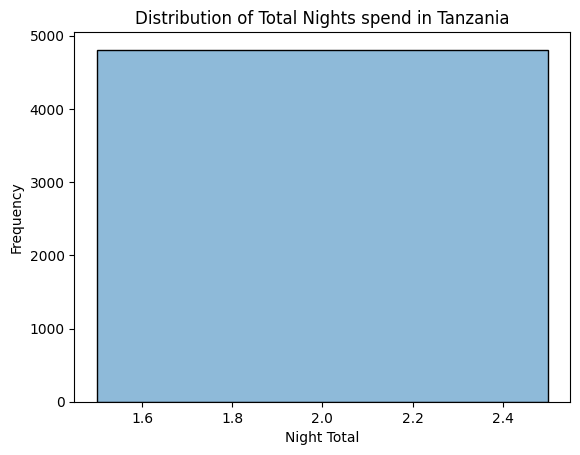

In [115]:
sns.histplot(df_train['night_total'], kde=True)
plt.title('Distribution of Total Nights spend in Tanzania')
plt.xlabel('Night Total')
plt.ylabel('Frequency')
plt.show()

In [43]:
df_train.total_cost.describe().round(2)

count        4809.00
mean      8114388.78
std      12224903.25
min         49000.00
25%        812175.00
50%       3397875.00
75%       9945000.00
max      99532875.00
Name: total_cost, dtype: float64

## Tour Arrangement 

In [117]:
df_train.tour_arrangement.unique()

array(['Independent', 'Package Tour'], dtype=object)

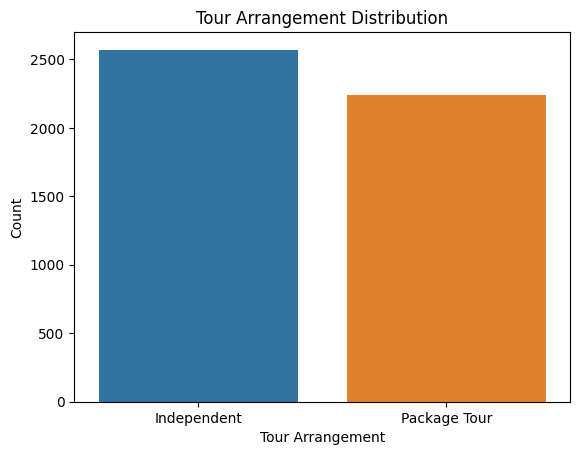

In [74]:
sns.countplot(x='tour_arrangement', data=df_train)
plt.title('Tour Arrangement Distribution')
plt.xlabel('Tour Arrangement')
plt.ylabel('Count')
plt.show()

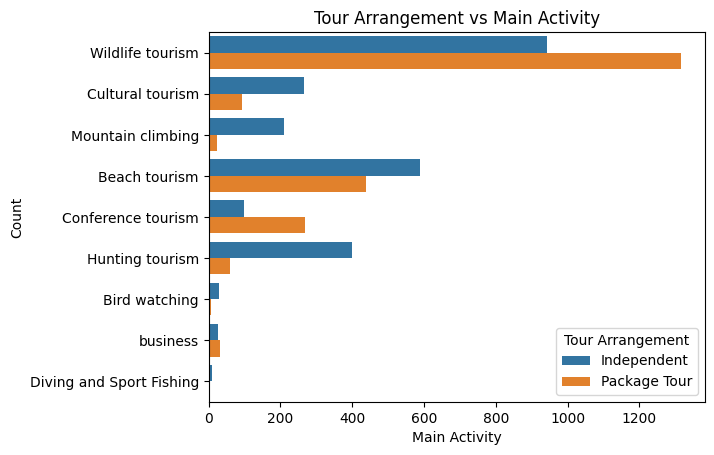

In [121]:
sns.countplot(y='main_activity', hue='tour_arrangement', data=df_train)
plt.title('Tour Arrangement vs Main Activity')
plt.xlabel('Main Activity')
plt.ylabel('Count')
plt.legend(title='Tour Arrangement')
plt.show()

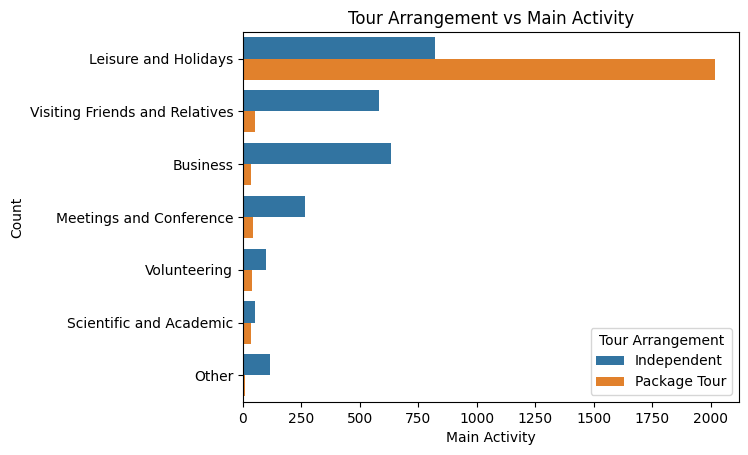

In [73]:
sns.countplot(y='purpose', hue='tour_arrangement', data=df_train)
plt.title('Tour Arrangement vs Main Activity')
plt.xlabel('Main Activity')
plt.ylabel('Count')
plt.legend(title='Tour Arrangement')
plt.show()

## Unique values of categorial columns

In [72]:
categories = ['most_impressing', 'purpose', 'main_activity', 'info_source', 'tour_arrangement', 'payment_mode']

for cat in categories:
    print('-'*80)
    print(f"[Category: {cat}] - [Null: {df_train[cat].isna().sum()}]\n")
    print(df_train[cat].value_counts())


--------------------------------------------------------------------------------
[Category: most_impressing] - [Null: 313]

most_impressing
Friendly People                         1541
Wildlife                                1038
No comments                              743
Wonderful Country, Landscape, Nature     507
Good service                             365
Excellent Experience                     271
Satisfies and Hope Come Back              31
Name: count, dtype: int64
--------------------------------------------------------------------------------
[Category: purpose] - [Null: 0]

purpose
Leisure and Holidays              2840
Business                           671
Visiting Friends and Relatives     633
Meetings and Conference            312
Volunteering                       138
Other                              128
Scientific and Academic             87
Name: count, dtype: int64
--------------------------------------------------------------------------------
[Category: main_a

In [ ]:
df_train.most_impressing.unique()

In [ ]:
df_train.purpose.unique()
#viewer.unique('purpose')

In [55]:
df_train.main_activity.unique()

array(['Wildlife tourism', 'Cultural tourism', 'Mountain climbing',
       'Beach tourism', 'Conference tourism', 'Hunting tourism',
       'Bird watching', 'business', 'Diving and Sport Fishing'],
      dtype=object)

In [61]:

# check those entries!!??!?!1!elf!
# df_train[df_train.main_activity == 'business']

In [ ]:
df_train.info_source.unique()

In [ ]:
df_train.tour_arrangement.unique()

In [ ]:
df_train.payment_mode.unique()

In [109]:
df_train.to_csv('savegame.csv')

In [83]:
df_train[df_train['most_impressing'].isna()] #.main_activity.unique()

,ID,country,age_group,travel_with,total_female,total_male,purpose,main_activity,info_source,tour_arrangement,...,night_zanzibar,payment_mode,first_trip_tz,most_impressing,total_cost,night_total,total_cost_log,single_female,single_male,single_traveler
8,tour_101,NIGERIA,25-44,Alone,1,1,Leisure and Holidays,Cultural tourism,"Travel, agent, tour operator",Independent,...,1,Cash,1,NaN,994500.0,4.0,13.809996,False,False,False
49,tour_1058,UAE,25-44,Alone,1,1,Visiting Friends and Relatives,Beach tourism,"Friends, relatives",Independent,...,1,Cash,0,NaN,1657500.0,8.0,14.320822,False,False,False
56,tour_1066,FRANCE,65+,Spouse,1,1,Visiting Friends and Relatives,Beach tourism,"Friends, relatives",Independent,...,1,Cash,1,NaN,2269330.0,56.0,14.634996,False,False,False
64,tour_1074,FRANCE,25-44,Alone,1,1,Leisure and Holidays,Cultural tourism,"Friends, relatives",Independent,...,1,Cash,1,NaN,400000.0,3.0,12.899222,False,False,False
82,tour_1098,SOUTH AFRICA,25-44,Friends/Relatives,1,1,Meetings and Conference,Mountain climbing,"Friends, relatives",Independent,...,1,Cash,0,NaN,414375.0,1.0,12.934529,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4690,tour_849,UGANDA,1-24,Alone,1,1,Visiting Friends and Relatives,Beach tourism,"Friends, relatives",Independent,...,1,Cash,0,NaN,663000.0,5.0,13.404532,False,False,False
4691,tour_85,GERMANY,45-64,Alone,1,1,Visiting Friends and Relatives,Beach tourism,"Friends, relatives",Independent,...,1,Cash,1,NaN,1657500.0,5.0,14.320822,False,False,False
4723,tour_889,NETHERLANDS,45-64,Friends/Relatives,1,1,Visiting Friends and Relatives,Wildlife tourism,"Friends, relatives",Independent,...,1,Credit Card,0,NaN,2486250.0,10.0,14.726287,False,False,False
4733,tour_902,BURUNDI,25-44,Alone,1,1,Meetings and Conference,Mountain climbing,"Friends, relatives",Package Tour,...,1,Cash,0,NaN,5967000.0,13.0,15.601755,False,False,False


## Target is total_cost

In [45]:
# scale the cost
df_train['total_cost_log'] = np.log1p(df_train['total_cost'])

y = df_train['total_cost_log']
X = df_train.drop('total_cost', axis=1)

In [46]:
corr=df_train.corr(numeric_only=True)

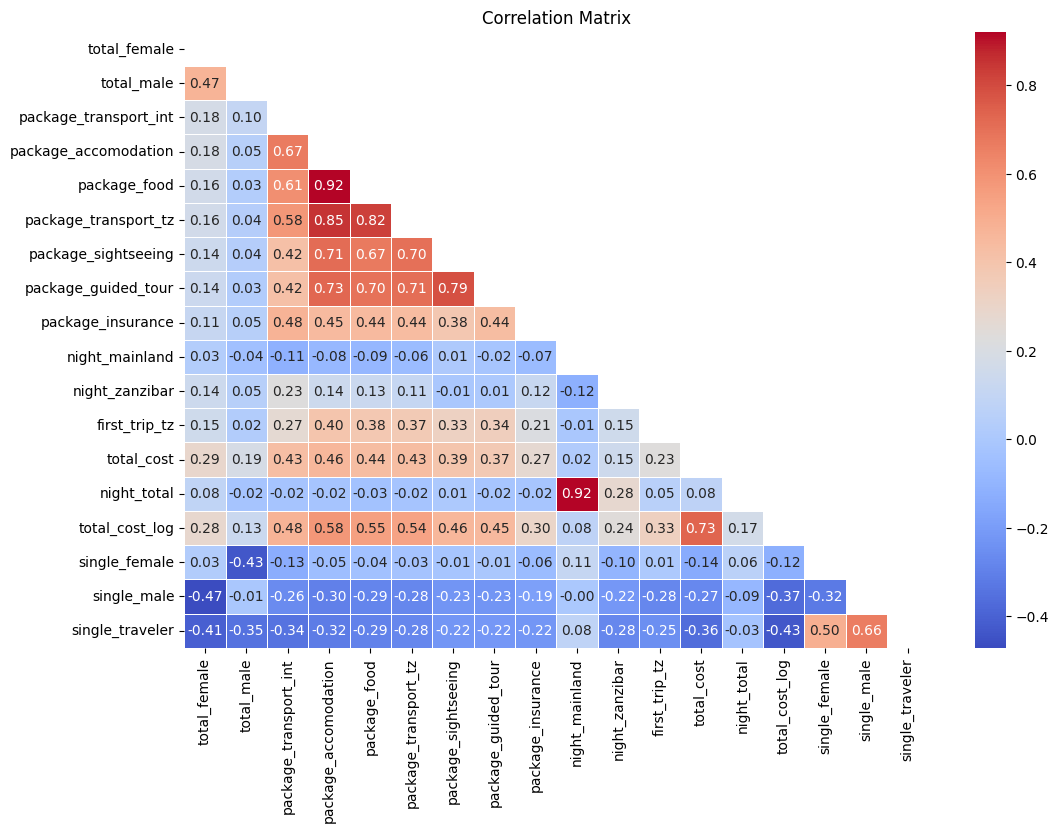

In [79]:
mask=np.triu(corr)
#sns.heatmap(corr);
plt.figure(figsize=(12, 8))
sns.heatmap(corr, mask=mask, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Correlation Matrix')
plt.show()

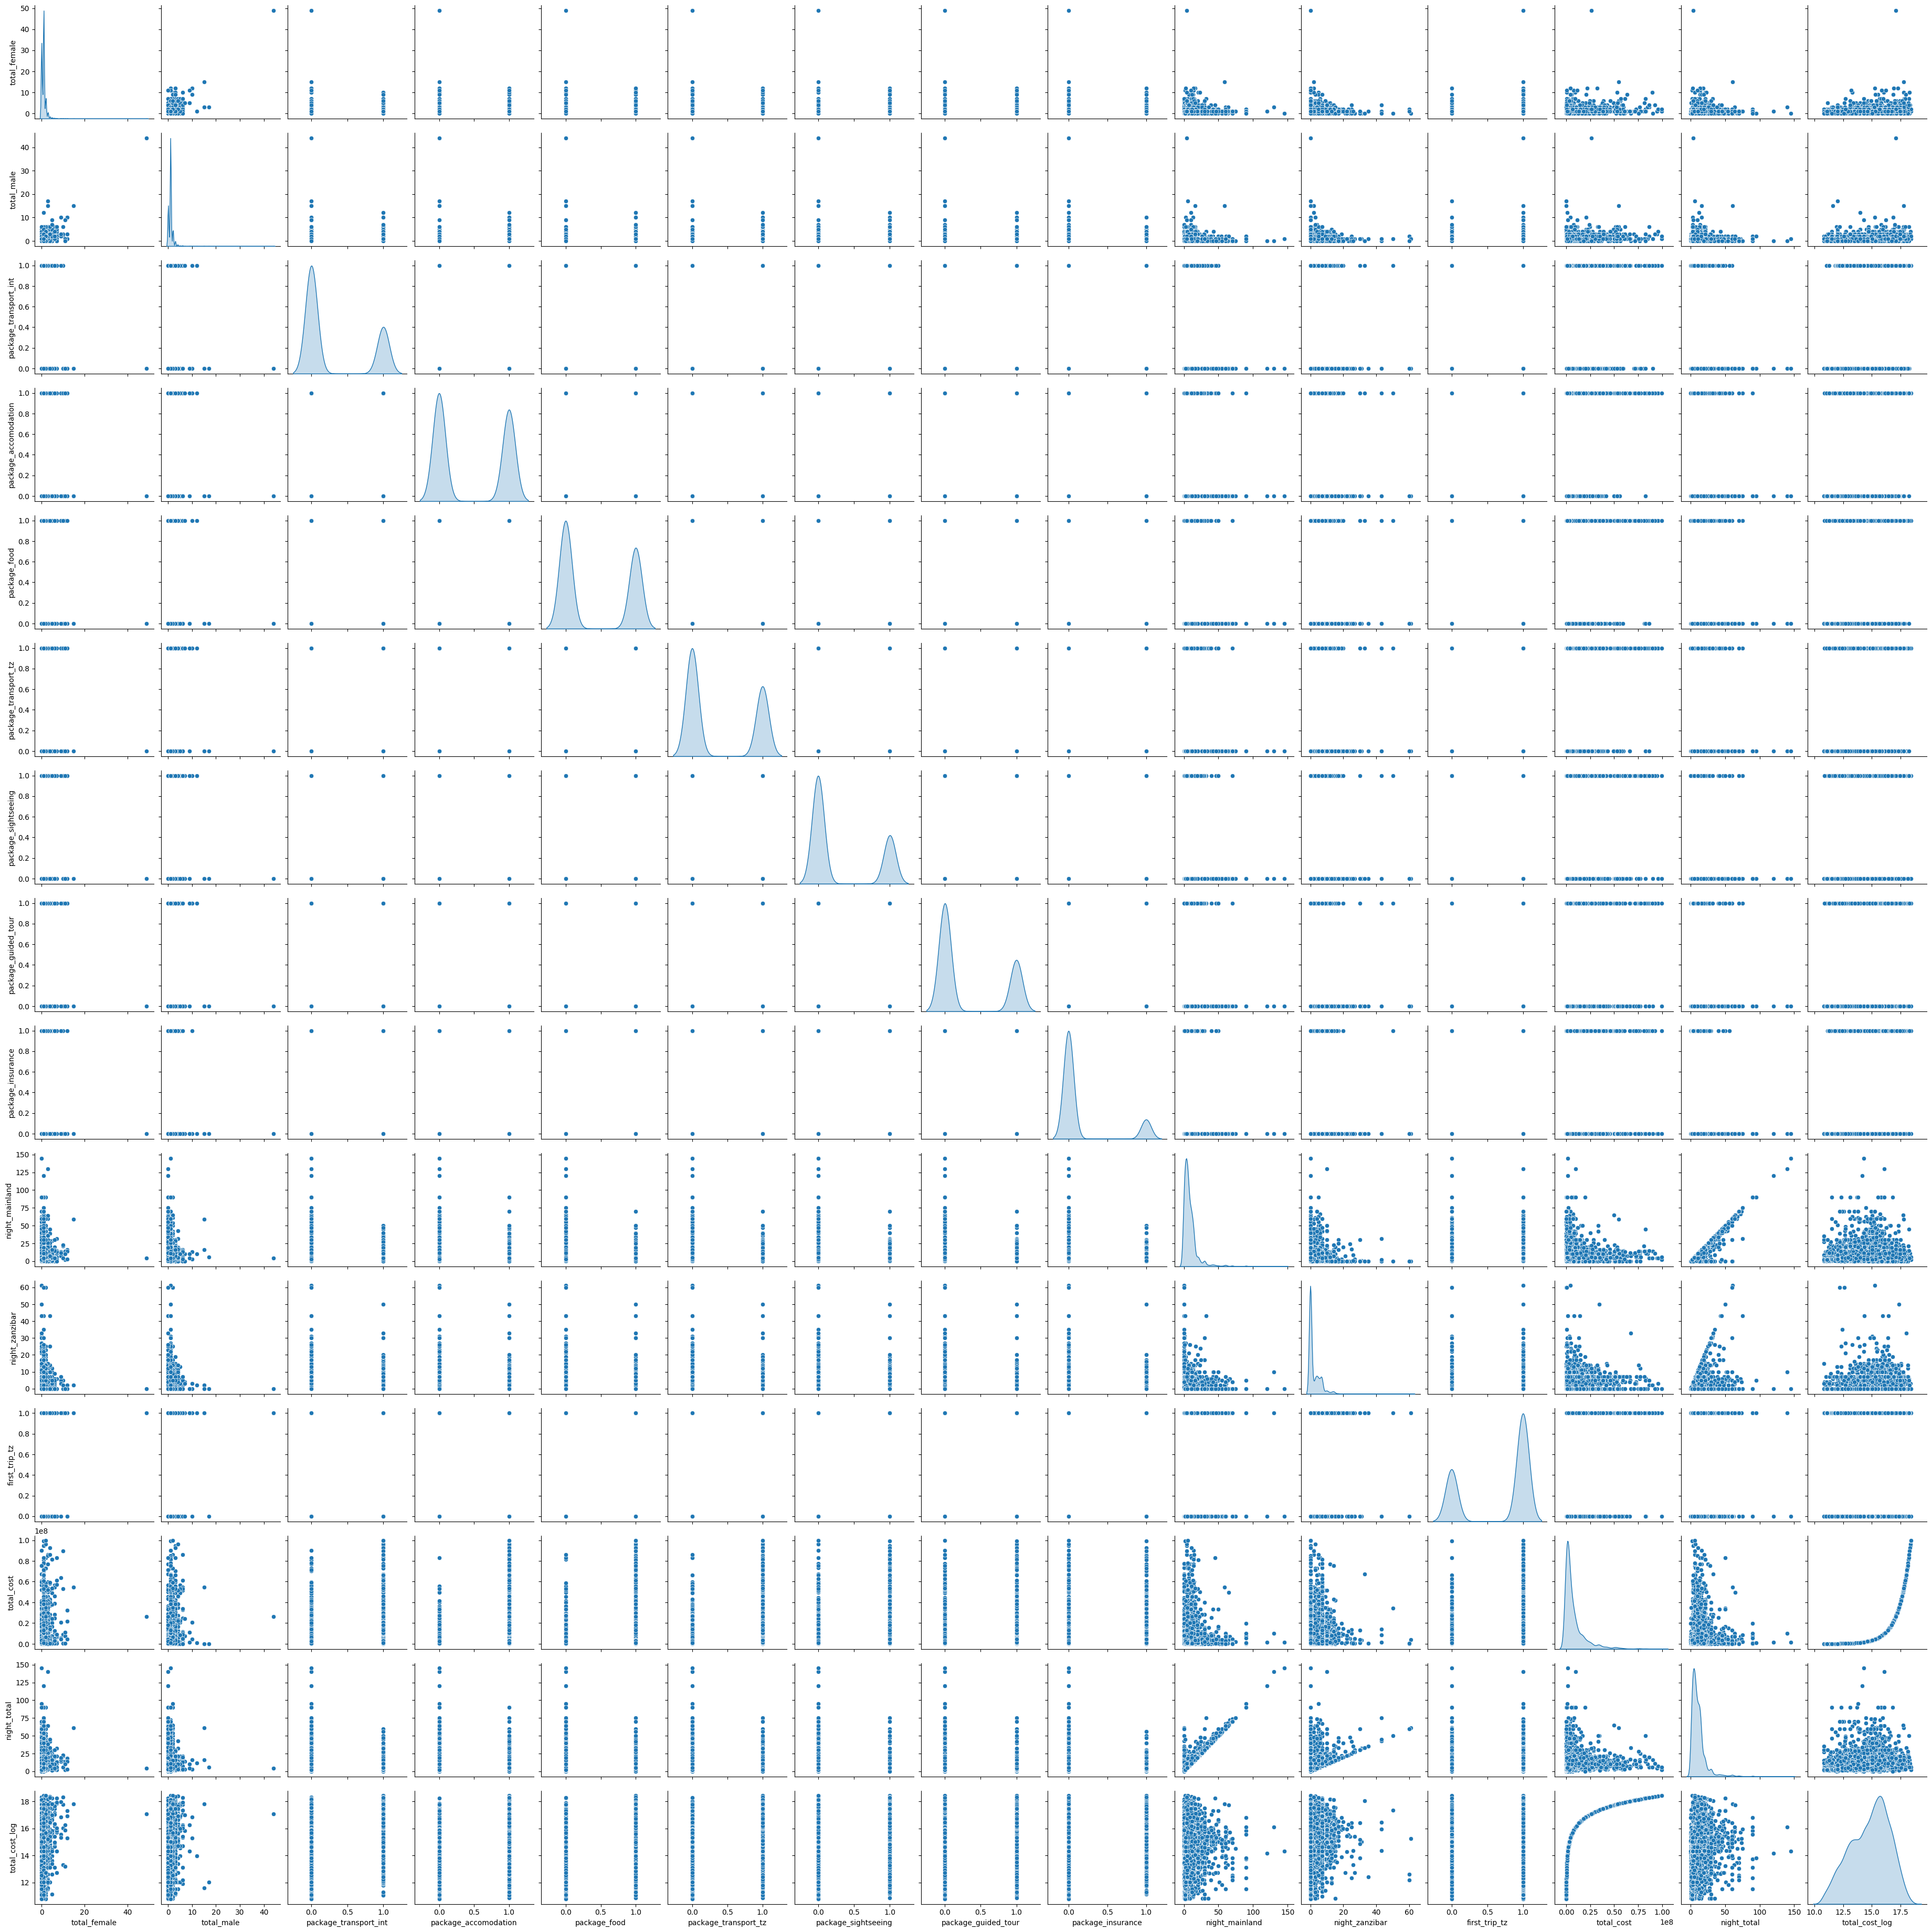

In [37]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
sns.pairplot(df_train, diag_kind='kde')
plt.show()

In [ ]:
#top_20_countries = df_train['country'].value_counts().index[:20]


## Plot the distribution of Age Groups

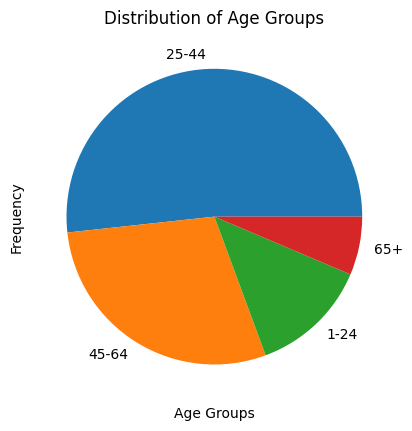

In [49]:
df_train['age_group'].value_counts().plot(kind='pie')
plt.title("Distribution of Age Groups")
plt.xlabel("Age Groups")
plt.ylabel("Frequency");

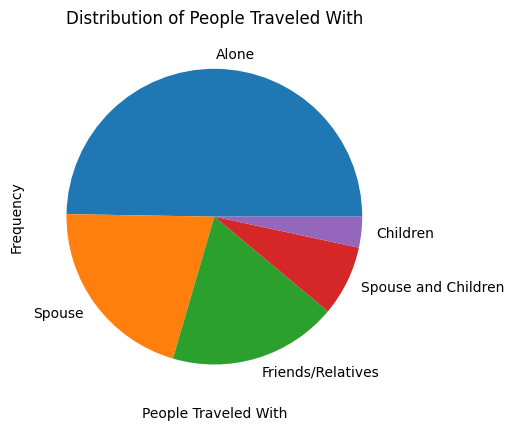

In [50]:
df_train['travel_with'].value_counts().plot(kind='pie') # bar, barh, 
plt.title("Distribution of People Traveled With")
plt.xlabel("People Traveled With")
plt.ylabel("Frequency");

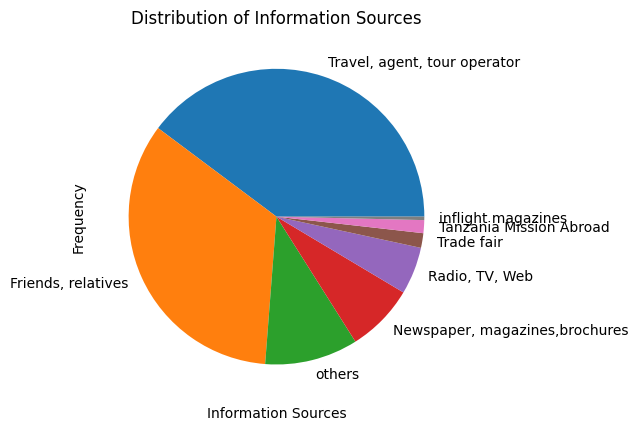

In [103]:
df_train['info_source'].value_counts().plot(kind='pie')
plt.title("Distribution of Information Sources")
plt.xlabel("Information Sources")
plt.ylabel("Frequency");

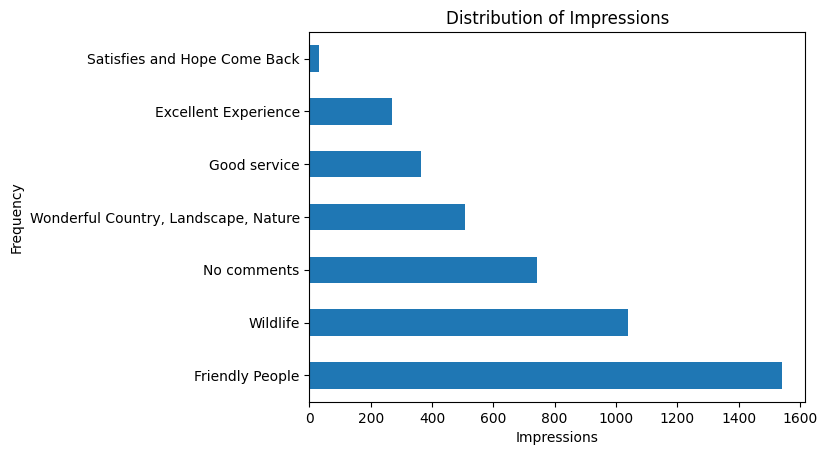

In [104]:
df_train['most_impressing'].value_counts().plot(kind='barh')
plt.title("Distribution of Impressions")
plt.xlabel("Impressions")
plt.ylabel("Frequency");

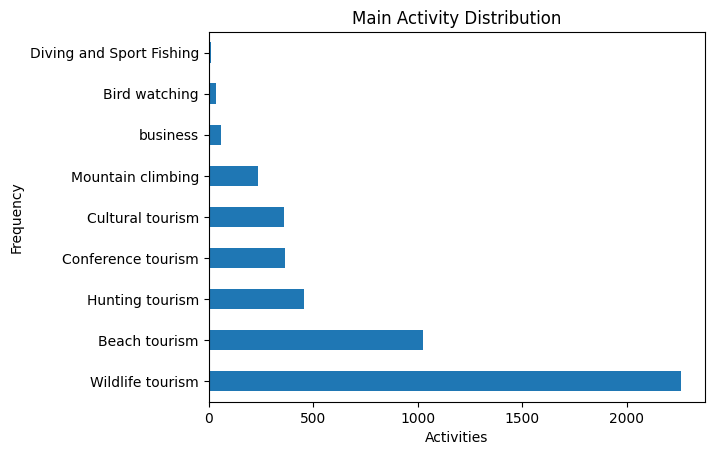

In [105]:
df_train['main_activity'].value_counts().plot(kind='barh')
plt.title("Main Activity Distribution")
plt.xlabel("Activities")
plt.ylabel("Frequency");